In [185]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

In [186]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [187]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [188]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
# See what's inside the engine and evaluate columns
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [189]:
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [190]:
# Get a list of column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [191]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [192]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [193]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [194]:
# Create our session (link) from Python to the DB
Session = Session(engine)

# Exploratory Precipitation Analysis

In [195]:
# Find the most recent date in the data set.
# In parenthesis, you are executing a SQL statement to figure most recent date
recent_date1= Session.execute("SELECT MAX(date) FROM Measurement").fetchall()
recent_date2=recent_date1[0][0]
print(recent_date2)

2017-08-23


In [196]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
init=dt.date.today()

# Calculate the date one year from the last date in data set.
last_date_format = init.replace(year=int(recent_date2[:4]),month=int(recent_date2[5:7]),day=int(recent_date2[8:]))
first_date = last_date_format - dt.timedelta(days=365) 
first_date = first_date.strftime("%Y-%m-%d")
# print(first_date)
# Perform a query to retrieve the data and precipitation scores
prec_data = Session.query(Measurement.date,Measurement.prcp)\
                          .filter(Measurement.date <= recent_date2)\
                          .filter(Measurement.date >= first_date)\
                          .order_by(Measurement.date.desc()).all()

# #To see all the data pull from the query
# for data in prec_data: 
#     print(data)

# Save the query results as a Pandas DataFrame and set the index to the date column
# And Sort the dataframe by date
prec_data_df = pd.DataFrame(prec_data).rename(columns={"date":"Date","prcp":"Precipitation Level"})
prec_data_df.set_index("Date",inplace=True)
prec_data_df.sort_values(by="Date")
prec_data_df.head()


,Precipitation Level
Date,
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-22,0.00


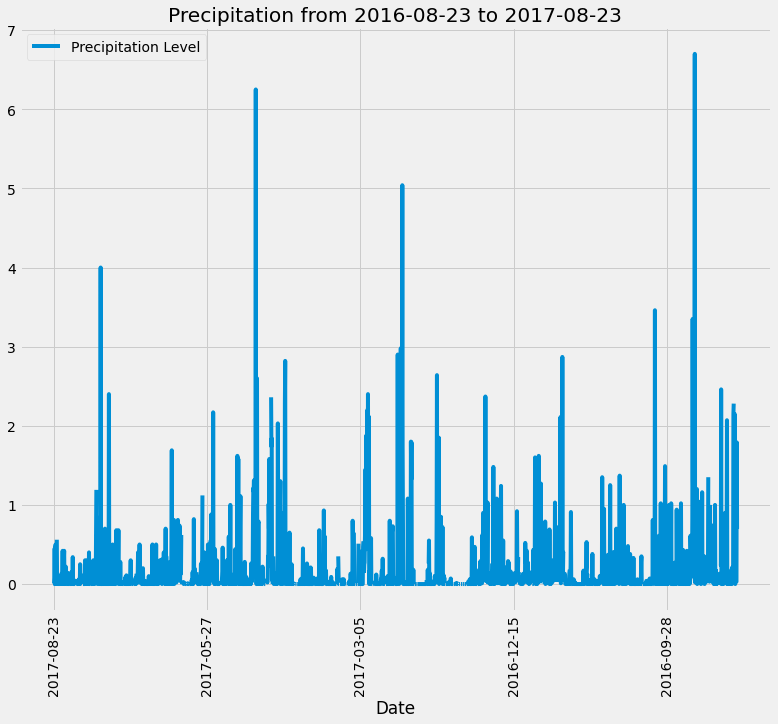

In [197]:
# Use Pandas Plotting with Matplotlib to plot the data
prec_data_df.plot(figsize=(12,10), rot=90, title=f'Precipitation from {first_date} to {recent_date2}')
plt.legend(loc="best")
plt.savefig("Images/Precipitation_Analysis.jpg")
plt.show()

In [198]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_data_df.describe()

,Precipitation Level
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [199]:
# Design a query to calculate the total number stations in the dataset
tot_stations = Session.query(Station).count()
print(tot_stations)

9


In [200]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = Session.query(Measurement.station,func.count(Measurement.station))\
                                     .group_by(Measurement.station)\
                                     .order_by(func.count(Measurement.station).desc()).all()
print(active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [201]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = active_stations[0][0]
stats = Session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)) \
                    .filter(Measurement.station == most_active).all()
print(f'Station: {most_active} // Lowest, Highest, Average Temps = {stats}')

Station: USC00519281 // Lowest, Highest, Average Temps = [(54.0, 85.0, 71.66378066378067)]


In [202]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_cont = Session.query(Measurement.tobs).filter(Measurement.station == most_active) \
                .filter(Measurement.date.between(first_date, recent_date2)).all()
# print(most_active_cont)

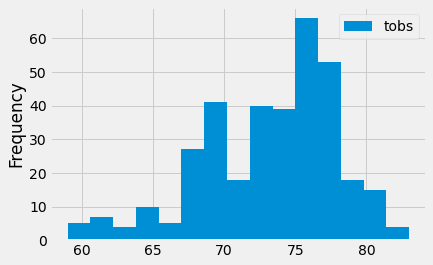

In [203]:
# Histogram based off above data, make a dataframe first
tobs_df = pd.DataFrame(most_active_cont, columns=['tobs'])
tobs_df.plot(kind='hist', bins=15)

# Close session

In [205]:
# Close Session
Session.close()